In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("hardware_downtime_backup.csv")
df.head()

,id,device_ip,device_name,time_down,time_up,mac_address,plant_code,location_name,plant_name,status,idel_time,last_active_time
0,231,10.235.125.61,WBCONTROLLER,2025-06-08 09:51:50,2025-06-08 09:56:45,NaN,N212,WB01,Tikariya,C,00:04:55,NaN
1,232,10.235.125.61,WBCONTROLLER,2025-06-08 10:21:50,2025-06-08 10:26:45,NaN,N212,WB01,Tikariya,C,00:04:55,NaN
2,233,10.235.125.66,WBCONTROLLER,2025-06-08 10:47:00,2025-06-08 10:51:55,NaN,N212,WB02,Tikariya,C,00:04:55,NaN
3,235,10.235.125.59,TRIP CLOSSER,2025-06-08 12:05:05,2025-06-09 15:49:50,NaN,N212,TRIP-CLOSSER,Tikariya,C,27:44:45,NaN
4,236,10.235.125.66,WBCONTROLLER,2025-06-08 12:12:00,2025-06-08 12:16:55,NaN,N212,WB02,Tikariya,C,00:04:55,NaN


In [5]:
df.drop(columns=["mac_address"], errors="ignore", inplace=True)

In [6]:
# Drop rows with nulls in critical columns
df.dropna(subset=["plant_name", "time_down", "time_up"], inplace=True)

In [7]:
# Convert to datetime
df["time_down"] = pd.to_datetime(df["time_down"], errors="coerce")
df["time_up"] = pd.to_datetime(df["time_up"], errors="coerce")

In [8]:
# Drop rows with invalid datetime
df.dropna(subset=["time_down", "time_up"], inplace=True)

In [9]:
# Remove future times or wrong order
df = df[df["time_up"] >= df["time_down"]]

In [10]:
# Calculate downtime in minutes
df["downtime_minutes"] = (df["time_up"] - df["time_down"]).dt.total_seconds() / 60

In [11]:
# Remove rows with downtime < 0
df = df[df["downtime_minutes"] >= 1]

In [12]:
df.isnull().sum()

id                     0
device_ip              0
device_name            0
time_down              0
time_up                0
plant_code             0
location_name          0
plant_name             0
status                 0
idel_time              0
last_active_time    2022
downtime_minutes       0
dtype: int64

In [13]:
df.drop(columns=["last_active_time"], errors="ignore", inplace=True)

In [14]:
df.isnull().sum()

id                  0
device_ip           0
device_name         0
time_down           0
time_up             0
plant_code          0
location_name       0
plant_name          0
status              0
idel_time           0
downtime_minutes    0
dtype: int64

In [15]:
# Drop extremely high downtime outliers (based on domain knowledge or IQR filtering)
q_high = df["downtime_minutes"].quantile(0.99)
df = df[df["downtime_minutes"] <= q_high]

In [16]:
# Add time-based features
df["down_hour"] = df["time_down"].dt.hour
df["down_day"] = df["time_down"].dt.dayofweek  # Monday=0
df["down_minute"] = df["time_down"].dt.minute
df["is_weekend"] = df["time_down"].dt.dayofweek.isin([5, 6]).astype(int)
df["month"] = df["time_down"].dt.month

In [17]:
# Save cleaned version
df.to_csv("cleaned_downtime.csv", index=False)
print("Cleaned downtime data saved to cleaned_downtime.csv")

Cleaned downtime data saved to cleaned_downtime.csv


### EDA Analysis

In [18]:
df = pd.read_csv("cleaned_downtime.csv", parse_dates=["time_down", "time_up"])
df.head()

,id,device_ip,device_name,time_down,time_up,plant_code,location_name,plant_name,status,idel_time,downtime_minutes,down_hour,down_day,down_minute,is_weekend,month
0,231,10.235.125.61,WBCONTROLLER,2025-06-08 09:51:50,2025-06-08 09:56:45,N212,WB01,Tikariya,C,00:04:55,4.916667,9,6,51,1,6
1,232,10.235.125.61,WBCONTROLLER,2025-06-08 10:21:50,2025-06-08 10:26:45,N212,WB01,Tikariya,C,00:04:55,4.916667,10,6,21,1,6
2,233,10.235.125.66,WBCONTROLLER,2025-06-08 10:47:00,2025-06-08 10:51:55,N212,WB02,Tikariya,C,00:04:55,4.916667,10,6,47,1,6
3,236,10.235.125.66,WBCONTROLLER,2025-06-08 12:12:00,2025-06-08 12:16:55,N212,WB02,Tikariya,C,00:04:55,4.916667,12,6,12,1,6
4,238,10.235.125.61,WBCONTROLLER,2025-06-08 14:16:50,2025-06-08 14:21:45,N212,WB01,Tikariya,C,00:04:55,4.916667,14,6,16,1,6


In [19]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                2001 non-null   int64         
 1   device_ip         2001 non-null   object        
 2   device_name       2001 non-null   object        
 3   time_down         2001 non-null   datetime64[ns]
 4   time_up           2001 non-null   datetime64[ns]
 5   plant_code        2001 non-null   object        
 6   location_name     2001 non-null   object        
 7   plant_name        2001 non-null   object        
 8   status            2001 non-null   object        
 9   idel_time         2001 non-null   object        
 10  downtime_minutes  2001 non-null   float64       
 11  down_hour         2001 non-null   int64         
 12  down_day          2001 non-null   int64         
 13  down_minute       2001 non-null   int64         
 14  is_weekend        2001 n

,id,time_down,time_up,downtime_minutes,down_hour,down_day,down_minute,is_weekend,month
count,2001.000000,2001,2001,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,3151.252374,2025-06-30 22:29:54.158920448,2025-06-30 22:36:48.505747200,6.905780,11.214393,3.752124,28.843078,0.412794,6.722139
min,231.000000,2025-06-08 09:51:50,2025-06-08 09:56:45,2.416667,0.000000,0.000000,0.000000,0.000000,6.000000
25%,2508.000000,2025-06-25 18:37:51,2025-06-25 19:57:46,4.850000,5.000000,2.000000,14.000000,0.000000,6.000000
50%,3377.000000,2025-07-04 08:33:20,2025-07-04 08:37:55,4.916667,11.000000,4.000000,30.000000,0.000000,7.000000
75%,4042.000000,2025-07-06 04:00:00,2025-07-06 04:05:05,4.916667,17.000000,5.000000,44.000000,1.000000,7.000000
max,4981.000000,2025-07-16 14:39:00,2025-07-16 16:10:00,109.966667,23.000000,6.000000,59.000000,1.000000,7.000000
std,1182.854977,NaN,NaN,9.115962,6.980151,1.871771,17.591514,0.492459,0.448056


In [20]:
df.shape

(2001, 16)

In [21]:
# Display basic stats
print(df["downtime_minutes"].describe())
print(df["downtime_minutes"].value_counts().head(10))

count    2001.000000
mean        6.905780
std         9.115962
min         2.416667
25%         4.850000
50%         4.916667
75%         4.916667
max       109.966667
Name: downtime_minutes, dtype: float64
downtime_minutes
4.916667    1082
4.833333     199
4.850000      57
4.933333      57
5.000000      53
4.750000      48
9.916667      40
4.766667      30
4.900000      21
4.683333      21
Name: count, dtype: int64


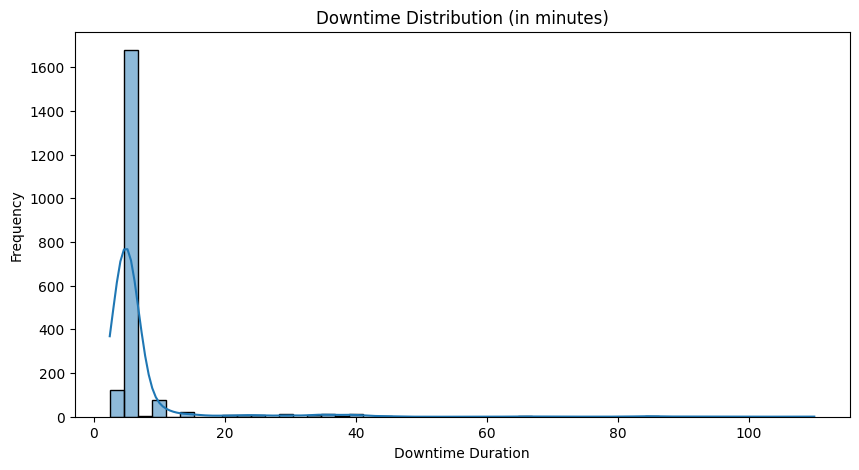

In [22]:
# Plot downtime distribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df["downtime_minutes"], bins=50, kde=True)
plt.title("Downtime Distribution (in minutes)")
plt.xlabel("Downtime Duration")
plt.ylabel("Frequency")
plt.show()

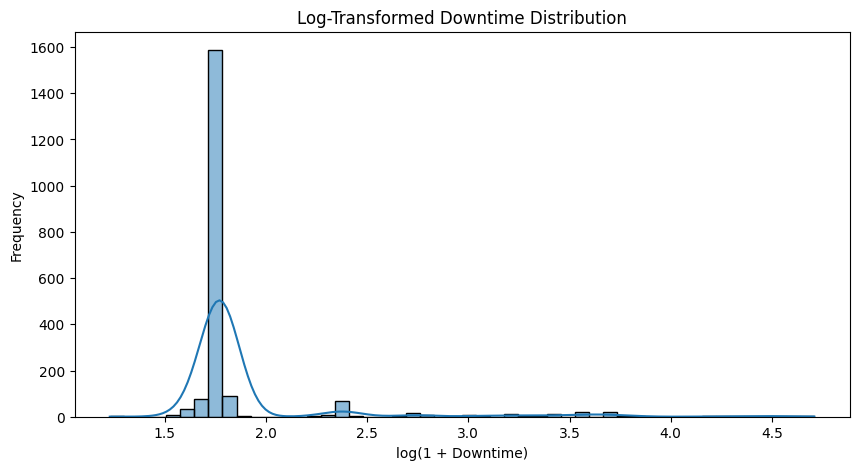

In [23]:
# Log-transformed downtime (to check long-tail)
plt.figure(figsize=(10, 5))
sns.histplot(df["downtime_minutes"].apply(lambda x: np.log1p(x)), bins=50, kde=True)
plt.title("Log-Transformed Downtime Distribution")
plt.xlabel("log(1 + Downtime)")
plt.ylabel("Frequency")
plt.show()

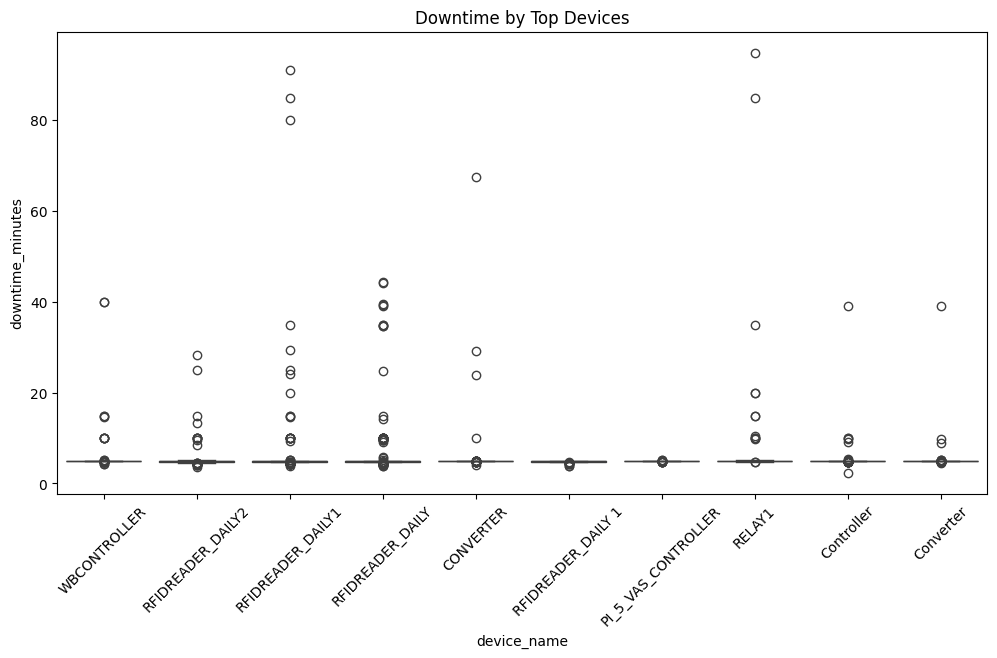

In [24]:
# Downtime by device
plt.figure(figsize=(12, 6))
top_devices = df["device_name"].value_counts().nlargest(10).index
sns.boxplot(data=df[df["device_name"].isin(top_devices)], x="device_name", y="downtime_minutes")
plt.xticks(rotation=45)
plt.title("Downtime by Top Devices")
plt.show()

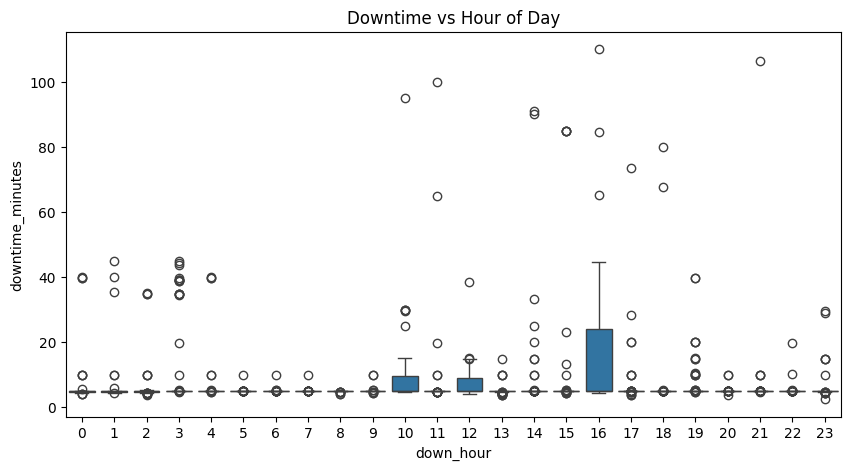

In [25]:
# Downtime by hour of the day
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="down_hour", y="downtime_minutes")
plt.title("Downtime vs Hour of Day")
plt.show()

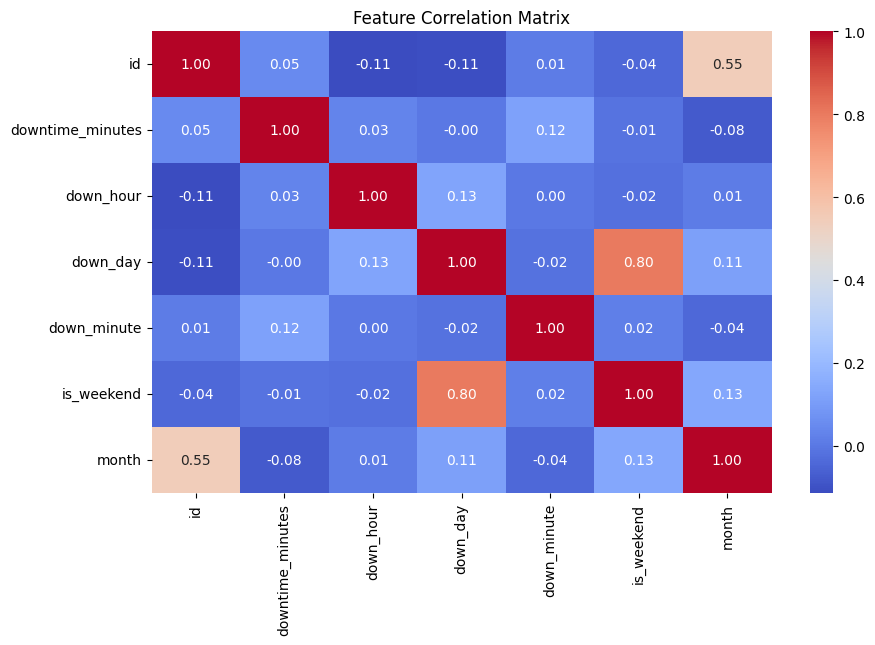

In [26]:
# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [27]:
from scipy.stats import skew
print("Skewness:", skew(df["downtime_minutes"]))

Skewness: 6.580929054437082


the skewness is extremely very high, Means most downtimes are short, but a few long ones pull the distribution heavily to the right (long tail).

<Axes: xlabel='down_hour', ylabel='downtime_minutes'>

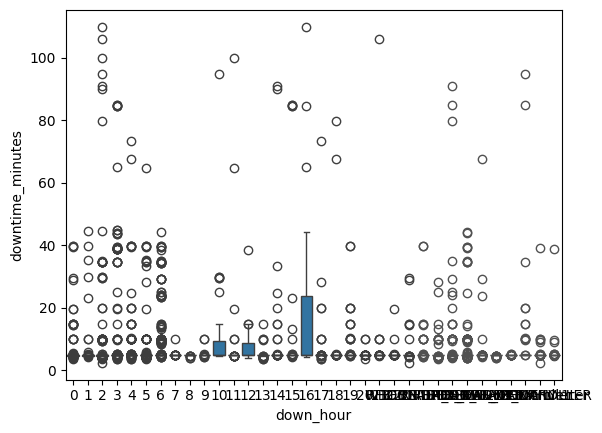

In [28]:
sns.boxplot(x="down_hour", y="downtime_minutes", data=df)
sns.boxplot(x="device_name", y="downtime_minutes", data=df[df["device_name"].isin(top_devices)])
sns.boxplot(x="down_day", y="downtime_minutes", data=df)

In [29]:
print(df["downtime_minutes"].value_counts().head(10))


downtime_minutes
4.916667    1082
4.833333     199
4.850000      57
4.933333      57
5.000000      53
4.750000      48
9.916667      40
4.766667      30
4.900000      21
4.683333      21
Name: count, dtype: int64


Handling highly skewed data 

In [30]:
def bin_downtime(x):
    if x <= 5:
        return "short"
    elif x <= 60:
        return "medium"
    elif x <= 360:
        return "long"
    else:
        return "very_long"

df["downtime_bin"] = df["downtime_minutes"].apply(bin_downtime)


In [31]:
df = pd.get_dummies(df, columns=["downtime_bin"], prefix="bin")

Applying Log transformation to reduce skew

In [32]:
import numpy as np

df["downtime_log"] = np.log1p(df["downtime_minutes"])


In [33]:
# #During prediction time (after model predicts the log values), you’ll reverse it using:
# predicted_minutes = np.expm1(predicted_log)

In [34]:
#adding feature for most common downtime (4.916667)
df["is_4_916667"] = (df["downtime_minutes"] == 4.916667).astype(int)


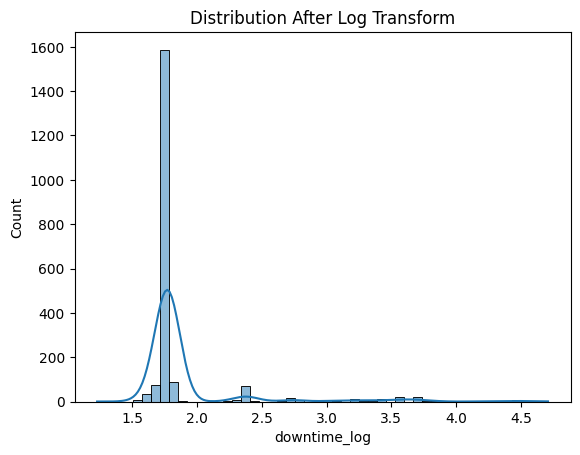

Skewness after log1p: 3.8118270516772785


In [35]:
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt

sns.histplot(df["downtime_log"], bins=50, kde=True)
plt.title("Distribution After Log Transform")
plt.show()

print("Skewness after log1p:", skew(df["downtime_log"]))

In [36]:
df.columns

Index(['id', 'device_ip', 'device_name', 'time_down', 'time_up', 'plant_code',
       'location_name', 'plant_name', 'status', 'idel_time',
       'downtime_minutes', 'down_hour', 'down_day', 'down_minute',
       'is_weekend', 'month', 'bin_long', 'bin_medium', 'bin_short',
       'downtime_log', 'is_4_916667'],
      dtype='object')

#### Step-2: Temporal Feature extraction

In [37]:
df["time_down"] = pd.to_datetime(df["time_down"])

df["dayofweek"] = df["time_down"].dt.dayofweek  # Monday = 0
df["dayofmonth"] = df["time_down"].dt.day


Step-2B Time since previous downtime

In [38]:
# Convert time_down to datetime if not already
df["time_down"] = pd.to_datetime(df["time_down"])

# Sort by device and timestamp
df = df.sort_values(by=["device_ip", "time_down"])

# Previous downtime per device
df["prev_time_down"] = df.groupby("device_ip")["time_down"].shift(1)

# Time since last failure in minutes
df["time_since_last_down"] = (df["time_down"] - df["prev_time_down"]).dt.total_seconds() / 60

# Fill NaNs with median
df["time_since_last_down"] = df["time_since_last_down"].fillna(df["time_since_last_down"].median())


In [39]:
df.columns

Index(['id', 'device_ip', 'device_name', 'time_down', 'time_up', 'plant_code',
       'location_name', 'plant_name', 'status', 'idel_time',
       'downtime_minutes', 'down_hour', 'down_day', 'down_minute',
       'is_weekend', 'month', 'bin_long', 'bin_medium', 'bin_short',
       'downtime_log', 'is_4_916667', 'dayofweek', 'dayofmonth',
       'prev_time_down', 'time_since_last_down'],
      dtype='object')

In [ ]:
# Step 0: Reset index completely to remove old timestamp index if exists
df = df.reset_index(drop=True)

# Step 1: Convert to datetime
df['timestamp'] = pd.to_datetime(df['prev_time_down'], errors='coerce')

# Step 2: Drop invalid timestamps
df = df.dropna(subset=['timestamp'])

# Step 3: Sort by device and timestamp
df = df.sort_values(['device_name', 'timestamp'])

# Step 4: Set timestamp as index (for rolling window)
df = df.set_index('timestamp')

# Step 5: Rolling count of recent failures per device in the past 1 day
df['recent_failures_1d'] = (
    df.groupby("device_name")["downtime_minutes"]
    .rolling("1d", min_periods=1)
    .count()
    .reset_index(level=0, drop=True)
)

# Step 6: Reset index again to continue with regular DataFrame usage
df = df.reset_index()

In [41]:
df["time_up"] = pd.to_datetime(df["time_up"])
df["prev_time_up"] = df.groupby("device_ip")["time_up"].shift(1)

df["time_since_last_up"] = (df["time_down"] - df["prev_time_up"]).dt.total_seconds() / 60

df["time_since_last_up"] = df["time_since_last_up"].fillna(df["time_since_last_up"].median())


In [42]:
df.head()

,timestamp,id,device_ip,device_name,time_down,time_up,plant_code,location_name,plant_name,status,...,bin_short,downtime_log,is_4_916667,dayofweek,dayofmonth,prev_time_down,time_since_last_down,recent_failures_1d,prev_time_up,time_since_last_up
0,2025-07-03 16:00:01,3972,10.235.162.143,Big LED,2025-07-04 19:15:13,2025-07-04 19:30:02,N239,YARD-OUT,Ametha,C,...,False,2.761064,0,4,4,2025-07-03 16:00:01,1635.200000,1.0,NaT,132.641667
1,2025-07-04 19:15:13,3973,10.235.162.143,Big LED,2025-07-04 19:34:57,2025-07-04 19:54:48,N239,YARD-OUT,Ametha,C,...,False,3.037354,0,4,4,2025-07-04 19:15:13,19.733333,1.0,2025-07-04 19:30:02,4.916667
2,2025-07-04 19:34:57,4009,10.235.162.143,Big LED,2025-07-05 01:59:47,2025-07-05 02:35:02,N239,YARD-OUT,Ametha,C,...,False,3.590439,0,5,5,2025-07-04 19:34:57,384.833333,2.0,2025-07-04 19:54:48,364.983333
3,2025-07-05 01:59:47,4022,10.235.162.143,Big LED,2025-07-05 03:30:02,2025-07-05 03:35:02,N239,YARD-OUT,Ametha,C,...,True,1.791759,0,5,5,2025-07-05 01:59:47,90.250000,3.0,2025-07-05 02:35:02,55.000000
4,2025-06-22 16:54:08,2427,10.236.250.23,CAMERA 1,2025-07-05 07:00:40,2025-07-05 07:05:35,NE03,WB01,Maratha,C,...,True,1.777773,0,5,5,2025-06-22 16:54:08,18126.533333,1.0,NaT,132.641667


#### Step-3 :Device level aggregates (group level features)

In [43]:
# First, ensure relevant columns are numeric
numeric_cols = [
    "downtime_minutes", "idel_time", 
    "time_since_last_down", "time_since_last_up"
]

# Convert to numeric just in case (e.g., in case of bad string data)
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now perform the groupby aggregation
device_agg = df.groupby("device_ip")[numeric_cols].agg({
    "downtime_minutes": ["mean", "median", "std", "max", "min", "count"],
    "idel_time": ["mean", "std", "max"],
    "time_since_last_down": ["mean"],
    "time_since_last_up": ["mean"]
})

# Flatten column names
device_agg.columns = ["_".join(col).strip() for col in device_agg.columns.values]
device_agg.reset_index(inplace=True)

# Merge back into main dataframe
df = df.merge(device_agg, on="device_ip", how="left")


successfully enhanced the dataset with the device-level statistical summaries - which often help xgboost pickup meaningful patterns

#### Step-4 Label Encoding

 Label Encoding for High-cardinality-safe Columns

In [44]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to encode
cat_cols = ["device_name", "plant_code", "location_name", "plant_name", "status"]

# Apply Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

applying target encoding:

we have high-cardinality categorical columns (likely many unique values) for device name so using target encoding only for device_name column

In [45]:
# Target encoding for 'device_name'
device_mean_downtime = df.groupby("device_name")["downtime_minutes"].mean()
df["device_name_te"] = df["device_name"].map(device_mean_downtime)

# (Optional) drop the original device_name if you're using only encoded version
df.drop("device_name", axis=1, inplace=True)


Data splitting

In [46]:
from sklearn.model_selection import train_test_split

y = df["downtime_minutes"]

drop_cols = [
    "id", "downtime_minutes", "time_down", "time_up", "downtime_log",
    "device_ip",  
]

if "device_name" in df.columns:
    drop_cols.append("device_name")

X = df.drop(columns=drop_cols)

print("Final feature columns:", X.columns.tolist())

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Final feature columns: ['timestamp', 'plant_code', 'location_name', 'plant_name', 'status', 'idel_time', 'down_hour', 'down_day', 'down_minute', 'is_weekend', 'month', 'bin_long', 'bin_medium', 'bin_short', 'is_4_916667', 'dayofweek', 'dayofmonth', 'prev_time_down', 'time_since_last_down', 'recent_failures_1d', 'prev_time_up', 'time_since_last_up', 'downtime_minutes_mean', 'downtime_minutes_median', 'downtime_minutes_std', 'downtime_minutes_max', 'downtime_minutes_min', 'downtime_minutes_count', 'idel_time_mean', 'idel_time_std', 'idel_time_max', 'time_since_last_down_mean', 'time_since_last_up_mean', 'device_name_te']


In [47]:
# Drop datetime columns from train and test
X_train = X_train.drop(columns=["prev_time_down", "prev_time_up"], errors="ignore")
X_test = X_test.drop(columns=["prev_time_down", "prev_time_up"], errors="ignore")


In [48]:
# Drop timestamp from features
X_train = X_train.drop(columns=['timestamp'], errors='ignore')
X_test = X_test.drop(columns=['timestamp'], errors='ignore')


Model Training

In [49]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f} minutes")
print(f"RMSE: {rmse:.2f} minutes")

R² Score: 0.9602
MAE: 0.44 minutes
RMSE: 1.84 minutes


In [50]:
import joblib

joblib.dump({
    'type': 'regression',
    'model': xgb_model
}, 'downtime_predictor_xgbmodel.pkl')


['downtime_predictor_xgbmodel.pkl']

In [52]:
import json

# For regression
with open("regression_model_features.json", "w") as f:
    json.dump(list(X_train.columns), f)

In [51]:
# import joblib
# joblib.dump(xgb_model, "downtime_predictor_xgbmodel.pkl")
